In [2]:

import imodels
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from bartpy2.sklearnmodel import SklearnModel 
from sklearn.metrics import mean_squared_error
from time import time
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor


In [3]:
X_bc, y_bc, feature_names = imodels.get_clean_dataset('breast_cancer', data_source='imodels')
X_bc_train, X_bc_test, y_bc_train, y_bc_test = train_test_split(X_bc, y_bc, test_size=0.25, random_state=42)

In [4]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {
#     'n_trees': [10, 20, 50],
#     'n_burn': [50, 100, 200],
#     'n_samples': [100, 200, 500]
# }

# # Initialize the BART model
# bart_model = SklearnModel()

# # Create the GridSearchCV object
# grid_search = GridSearchCV(bart_model, param_grid, cv=3, scoring='roc_auc')

# # Fit GridSearchCV
# grid_search.fit(X_bc_train, y_bc_train)

# # Print the best parameters and the best score
# print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_) 


In [5]:

#scaler = MinMaxScaler(feature_range=(0, 1))

# Define the parameter grid
# param_grid = {
#     'n_trees': [10, 20, 50],
#     'n_burn': [50, 100, 200],
#     'n_samples': [100, 200, 500]
# }

# # Initialize a list to store the results
# results = []

# # Iterate over each combination of parameters
# for params in ParameterGrid(param_grid):
#     # Initialize the BART model with current parameters
#     bart_model = SklearnModel(n_trees=params['n_trees'], n_burn=params['n_burn'], n_samples=params['n_samples'])
    
#     # Start timing
#     start_time = time()
    
#     # Fit the model
#     bart_model.fit(X_bc_train, y_bc_train)
    
#     # Predict
#     y_pred_proba = bart_model.predict(X_bc_test)
#     #normalized_proba = scaler.fit_transform(y_pred_proba)
#     y_pred = (y_pred_proba > 0.5).astype(int) 

    
#     # Calculate F1 score
#     mse = mean_squared_error(y_bc_test, y_pred)
    
    
#     # Stop timing
#     time_elapsed = time() - start_time
    
#     # Append the results to the list
#     results.append({
#         'n_trees': params['n_trees'],
#         'n_burn': params['n_burn'],
#         'n_samples': params['n_samples'],
#         'time_elapsed': time_elapsed,
#         'mse': mse
#     })
# results_bc = pd.DataFrame(results)

In [6]:
# results_bc

In [7]:

def get_model_score(X_train, y_train, X_test, y_test, model, metric):
    model.fit(X_train, y_train)
    preds_test_prob = model.predict(X_test)
    #y_pred = (preds_test_prob > 0.5).astype(int) 
    score = metric(y_test, preds_test_prob)
    return score

def make_model(model_params_dict):
    model =  SklearnModel(**model_params_dict)
    return model

def make_dgp(dataset_name):
    X, y, feature_names = imodels.get_clean_dataset(dataset_name, data_source='imodels')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    return X_train, X_test, y_train,y_test

In [8]:
## running one step of  simulation 

def run_one_dgp_iter(dataset_name, model_params_dict, metric=mean_squared_error
                     ):
    X_train, X_test, y_train,y_test = make_dgp(dataset_name)
    results = []
    
    model = make_model(model_params_dict)
    start_time = time()
    score = get_model_score(X_train, y_train, X_test, y_test, model, metric)
    time_elapsed = time() - start_time
    results.append({
        'dataset': dataset_name,
        'n_trees': model_params_dict['n_trees'],
        'sigma_a': model_params_dict['sigma_a'],
        'sigma_b': model_params_dict['sigma_b'],
        'time_elapsed': time_elapsed,
        'mse': score
            })
    return results

def one_comparsion(dataset_names, model_params_dict, metric=mean_squared_error
                     ):
    results = []
    
    for dataset_name in dataset_names:
        X_train, X_test, y_train,y_test = make_dgp(dataset_name)
    
    # bart model
        model = make_model(model_params_dict)
        start_time = time()
        score = get_model_score(X_train, y_train, X_test, y_test, model, metric)
        time_elapsed = time() - start_time
        results.append({
            'dataset': dataset_name,
            'method':'BART',
            'n_trees': model_params_dict['n_trees'],
            'sigma_a': model_params_dict['sigma_a'],
            'sigma_b': model_params_dict['sigma_b'],
            'time_elapsed': time_elapsed,
            'mse': score
        })
    
    #random forest part
        modelr = RandomForestRegressor()
        start_time_r = time()
        score_r = get_model_score(X_train, y_train, X_test, y_test, modelr, metric)
        time_elapsed_r = time() - start_time_r

        results.append({
            'dataset': dataset_name,
            'method':'RandomForest',
            'n_trees': model_params_dict['n_trees'],
            'sigma_a': model_params_dict['sigma_a'],
            'sigma_b': model_params_dict['sigma_b'],
            'time_elapsed': time_elapsed_r,
            'mse': score_r
            })
    #results = pd.DataFrame(results)
    return results

In [9]:
params = {'n_trees': 100,'sigma_a' : 0.5,"sigma_b" : 0.25}
dataset_names=['breast_cancer','heart']

In [10]:
one_comparsion(dataset_names=dataset_names,model_params_dict=params)

fetching heart from imodels


[{'dataset': 'breast_cancer',
  'method': 'BART',
  'n_trees': 100,
  'sigma_a': 0.5,
  'sigma_b': 0.25,
  'time_elapsed': 12.406075716018677,
  'mse': 0.1610143342884147},
 {'dataset': 'breast_cancer',
  'method': 'RandomForest',
  'n_trees': 100,
  'sigma_a': 0.5,
  'sigma_b': 0.25,
  'time_elapsed': 0.10141468048095703,
  'mse': 0.1640196292638484},
 {'dataset': 'heart',
  'method': 'BART',
  'n_trees': 100,
  'sigma_a': 0.5,
  'sigma_b': 0.25,
  'time_elapsed': 10.88571810722351,
  'mse': 0.11622961613821395},
 {'dataset': 'heart',
  'method': 'RandomForest',
  'n_trees': 100,
  'sigma_a': 0.5,
  'sigma_b': 0.25,
  'time_elapsed': 0.12053608894348145,
  'mse': 0.13922352941176475}]

In [11]:
from tqdm import tqdm
n_iter = 5
def bartpy2(dataset_names,dgp_params_dict_list_bartpy2, metric=mean_squared_error,
         n_iter=n_iter):
    results = []
    for iter_num in tqdm(range(n_iter)):
        results+= one_comparsion(dataset_names, dgp_params_dict_list_bartpy2)
    result= pd.DataFrame(results)
    return result

result = bartpy2(dataset_names,params,n_iter)

  0%|          | 0/5 [00:00<?, ?it/s]

fetching heart from imodels


 20%|██        | 1/5 [00:22<01:30, 22.69s/it]

fetching heart from imodels


 40%|████      | 2/5 [00:45<01:07, 22.50s/it]

fetching heart from imodels


 60%|██████    | 3/5 [01:07<00:44, 22.50s/it]

fetching heart from imodels


 80%|████████  | 4/5 [01:30<00:22, 22.53s/it]

fetching heart from imodels


100%|██████████| 5/5 [01:52<00:00, 22.56s/it]


In [12]:
result

,dataset,method,n_trees,sigma_a,sigma_b,time_elapsed,mse
0,breast_cancer,BART,100,0.5,0.25,11.236999,0.161442
1,breast_cancer,RandomForest,100,0.5,0.25,0.100585,0.163093
2,heart,BART,100,0.5,0.25,11.041932,0.115713
3,heart,RandomForest,100,0.5,0.25,0.120712,0.132713
4,breast_cancer,BART,100,0.5,0.25,11.163678,0.158616
5,breast_cancer,RandomForest,100,0.5,0.25,0.104515,0.161562
6,heart,BART,100,0.5,0.25,10.816249,0.114955
7,heart,RandomForest,100,0.5,0.25,0.119689,0.142246
8,breast_cancer,BART,100,0.5,0.25,11.114329,0.158847
9,breast_cancer,RandomForest,100,0.5,0.25,0.097252,0.162397


0             BARTbreast_cancer
1     RandomForestbreast_cancer
2                     BARTheart
3             RandomForestheart
4             BARTbreast_cancer
5     RandomForestbreast_cancer
6                     BARTheart
7             RandomForestheart
8             BARTbreast_cancer
9     RandomForestbreast_cancer
10                    BARTheart
11            RandomForestheart
12            BARTbreast_cancer
13    RandomForestbreast_cancer
14                    BARTheart
15            RandomForestheart
16            BARTbreast_cancer
17    RandomForestbreast_cancer
18                    BARTheart
19            RandomForestheart
Name: Combined, dtype: object

In [53]:
result['Combined'] = result['method'] + result['dataset']
grouped = result.groupby('Combined')
grouped['mse'].mean()
#grouped['time_elapsed'].std()


Combined
BARTbreast_cancer            0.159748
BARTheart                    0.115182
RandomForestbreast_cancer    0.162261
RandomForestheart            0.141329
Name: mse, dtype: float64

In [77]:
pd.DataFrame(grouped['mse'].mean()).iloc[5:].iloc[:0]

,mse
Combined,


In [78]:
a=pd.DataFrame(grouped)

stats_df = pd.DataFrame({
    #'combined':a[0],
    'Mean_MSE':grouped['mse'].mean(),
    'Mean_time':grouped['time_elapsed'].mean(),
    'SD_MSE':grouped['mse'].std(),
    'SD_time':grouped['time_elapsed'].std()
})
stats_df


,Mean_MSE,Mean_time,SD_MSE,SD_time
Combined,,,,
BARTbreast_cancer,0.159748,11.160919,0.001161,0.048417
BARTheart,0.115182,10.998261,0.001431,0.112840
RandomForestbreast_cancer,0.162261,0.100000,0.000975,0.003216
RandomForestheart,0.141329,0.122001,0.006033,0.003055


In [83]:
print(stats_df.index.tolist())

['BARTbreast_cancer', 'BARTheart', 'RandomForestbreast_cancer', 'RandomForestheart']


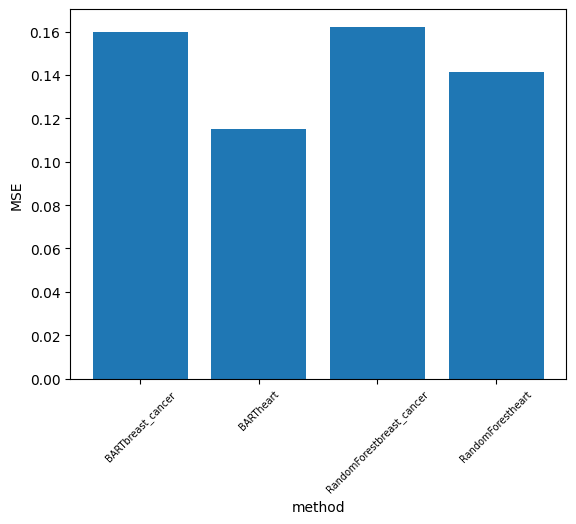

In [91]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(8, 4))  # Optional, to adjust figure size
plt.bar(stats_df.index,stats_df['Mean_MSE'])  # You can customize color
plt.xlabel('method')
plt.ylabel('MSE')
plt.xticks(rotation=45,fontsize=7)
plt.show()


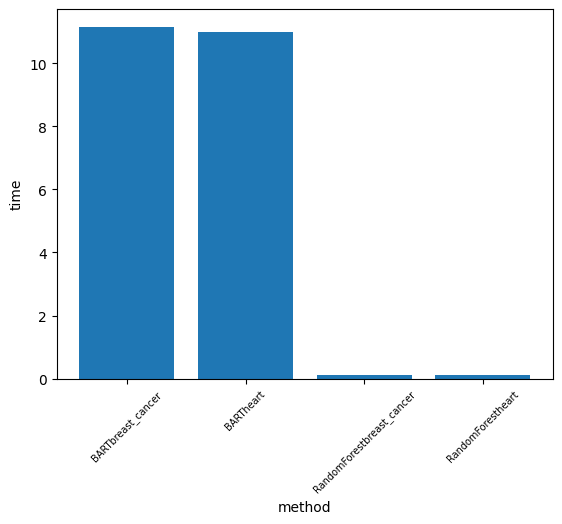

In [89]:
plt.bar(stats_df.index,stats_df['Mean_time'])  # You can customize color
plt.xlabel('method')
plt.ylabel('time')
plt.xticks(rotation=45,fontsize=7)
plt.show()
